<a href="https://colab.research.google.com/github/arnaldourbina/HACKATON_Equipo_H12-25-L-Equipo74/blob/main/Notebook_flight_on_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**✈️PREDICCIÓN DE RETRASOS DE VUELOS**

#**1. Importando las librerías**

In [3]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os


#**2. Lectura de los datos**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

datos = pd.read_csv("/content/drive/MyDrive/HACKATHON/ARCHIVOS 2015/flight_clean.csv")

datos.head(5)

/tmp/ipython-input-2759207130.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  datos = pd.read_csv("/content/drive/MyDrive/HACKATHON/ARCHIVOS 2015/flight_clean.csv")


,Unnamed: 0,ANO,MES,DIA,DIA_SEMANA,AEROLINEA,NUMERO_VUELO,NUMERO_DEL_AVION,AEROPUERTO_ORIGEN,AEROPUERTO_DESTINO,...,DESVIADO,CANCELADO,RAZON_CANCELACION,RETRASO_SISTEMA_AEREO,RETRASO_SEGURIDAD,RETRASO_AEROLINEA,RETRASO_AVION_TARDIO,RETRASO_CLIMA,LLEGADA_PROGRAMA,RETRASO_GRAVE
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,...,0,0,No Cancelado,0.0,0.0,0.0,0.0,0.0,7.166667,0
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,...,0,0,No Cancelado,0.0,0.0,0.0,0.0,0.0,12.500000,0
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,...,0,0,No Cancelado,0.0,0.0,0.0,0.0,0.0,13.433333,0
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,...,0,0,No Cancelado,0.0,0.0,0.0,0.0,0.0,13.416667,0
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,...,0,0,No Cancelado,0.0,0.0,0.0,0.0,0.0,5.333333,0


In [6]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


/tmp/ipython-input-1508475793.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="AEROLINEA", y="RETRASO_TOTAL", data=datos, palette="Set3")


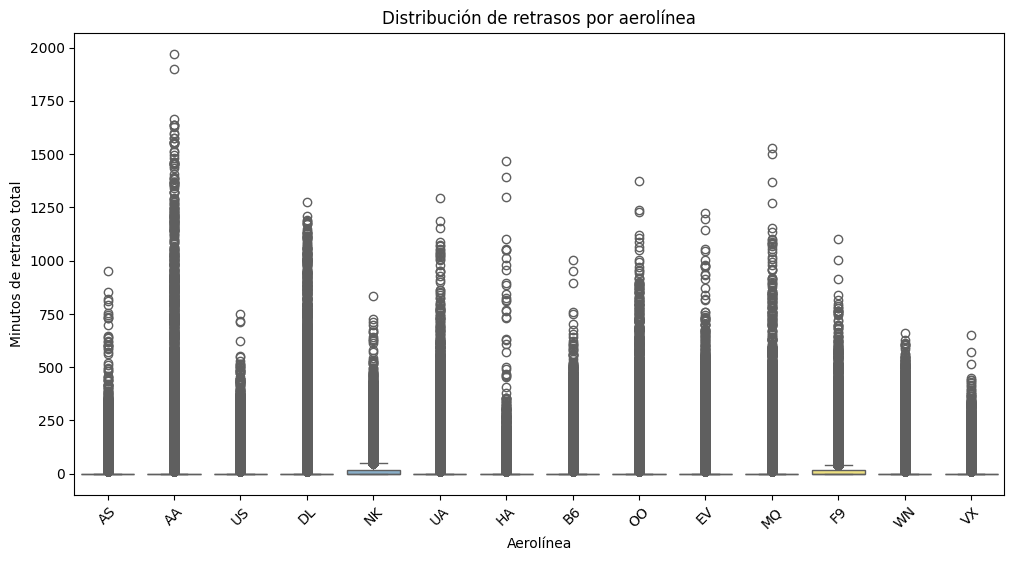

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

causas = ['RETRASO_SISTEMA_AEREO','RETRASO_SEGURIDAD',
          'RETRASO_AEROLINEA','RETRASO_AVION_TARDIO','RETRASO_CLIMA']
datos["RETRASO_TOTAL"] = datos[causas].sum(axis=1)
datos["RETRASO_GRAVE"] = (datos["RETRASO_TOTAL"] >= 30).astype(int)

plt.figure(figsize=(12,6))
sns.boxplot(x="AEROLINEA", y="RETRASO_TOTAL", data=datos, palette="Set3")

plt.title("Distribución de retrasos por aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Minutos de retraso total")
plt.xticks(rotation=45)
plt.savefig("Distribución_de_retrasos_por_aerolínea.png", dpi=300)
plt.show()

/tmp/ipython-input-2588211072.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proporciones = datos.groupby("FRANJA_HORARIA_LLEGADA")["RETRASO_GRAVE"].mean()


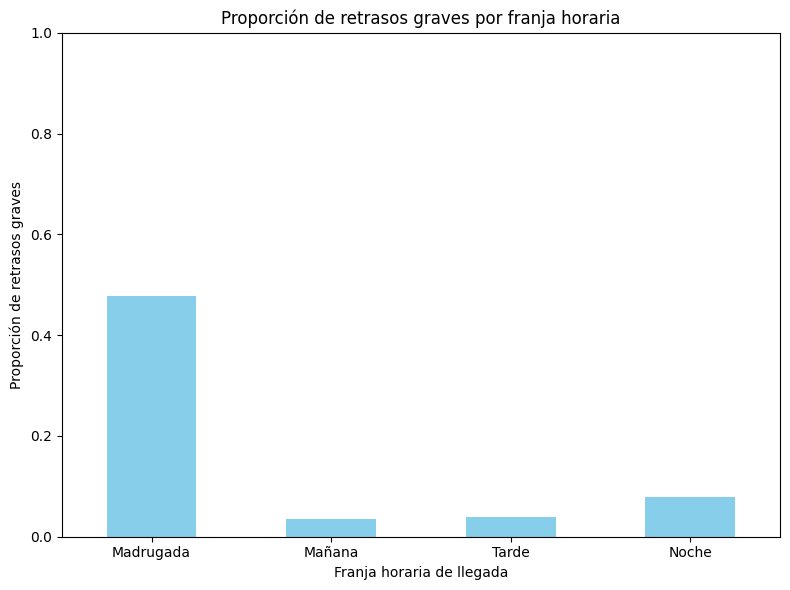

In [11]:
import matplotlib.pyplot as plt


# 1. Calcular proporción de retrasos graves por franja horaria
datos["HORA_LLEGADA"] = pd.to_numeric(datos["HORA_LLEGADA"], errors="coerce")
datos["HORA_LLEGADA"] = datos["HORA_LLEGADA"].fillna(datos["HORA_LLEGADA"].mean()).astype(int)

datos["FRANJA_HORARIA_LLEGADA"] = pd.cut(datos["HORA_LLEGADA"],
                                         bins=[0,6,12,18,24],
                                         labels=["Madrugada","Mañana","Tarde","Noche"],
                                         right=False)

proporciones = datos.groupby("FRANJA_HORARIA_LLEGADA")["RETRASO_GRAVE"].mean()

# 2. Crear gráfico de barras
plt.figure(figsize=(8,6))
proporciones.plot(kind="bar", color="skyblue")

plt.title("Proporción de retrasos graves por franja horaria")
plt.ylabel("Proporción de retrasos graves")
plt.xlabel("Franja horaria de llegada")
plt.xticks(rotation=0)
plt.ylim(0,1)  # porque es proporción entre 0 y 1
plt.tight_layout()
plt.savefig("Proporción_de_retrasos_graves_por_franja_horaria.png", dpi=300)
plt.show()

/tmp/ipython-input-746051124.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proporciones_temp = datos.groupby("TEMPORADA")["RETRASO_GRAVE"].mean()


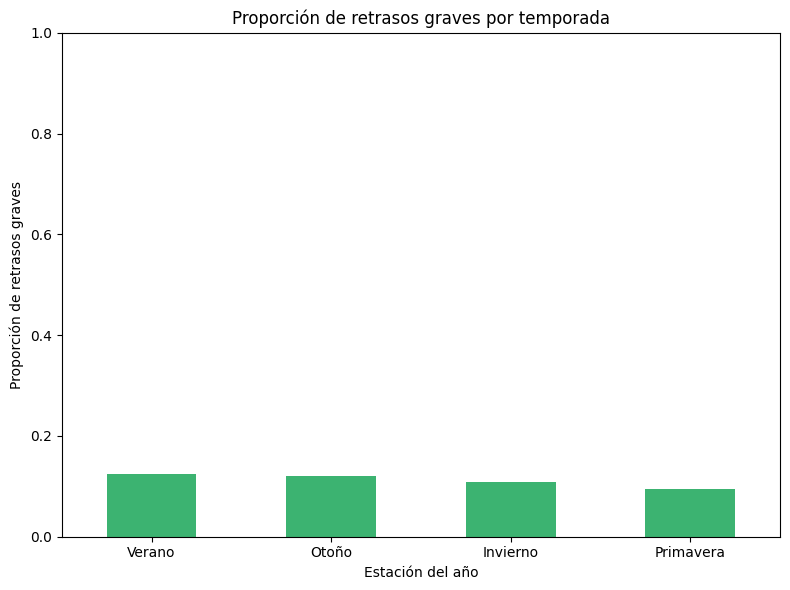

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear variables derivadas
datos["FECHA_COMPLETA"] = pd.to_datetime(
    datos[["ANO","MES","DIA"]].rename(columns={"ANO":"year","MES":"month","DIA":"day"})
)

datos["DIA_SEMANA"] = datos["FECHA_COMPLETA"].dt.dayofweek
datos["MES_PARTIDA"] = datos["FECHA_COMPLETA"].dt.month
datos["ES_FIN_DE_SEMANA"] = datos["DIA_SEMANA"].isin([5,6]).astype(int)

# Definir temporadas (hemisferio norte con pd.cut)
datos["TEMPORADA"] = pd.cut(
    datos["MES_PARTIDA"],
    bins=[0,3,6,9,12],
    labels=["Verano","Otoño","Invierno","Primavera"],
    right=True
)

# Calcular proporción de retrasos graves por temporada
proporciones_temp = datos.groupby("TEMPORADA")["RETRASO_GRAVE"].mean()

# Graficar
plt.figure(figsize=(8,6))
proporciones_temp.plot(kind="bar", color="mediumseagreen")

plt.title("Proporción de retrasos graves por temporada")
plt.ylabel("Proporción de retrasos graves")
plt.xlabel("Estación del año")
plt.xticks(rotation=0)
plt.ylim(0,1)  # proporción entre 0 y 1
plt.tight_layout()
plt.savefig("Proporción_de_retrasos_graves_por_temporada.png", dpi=300)
plt.show()

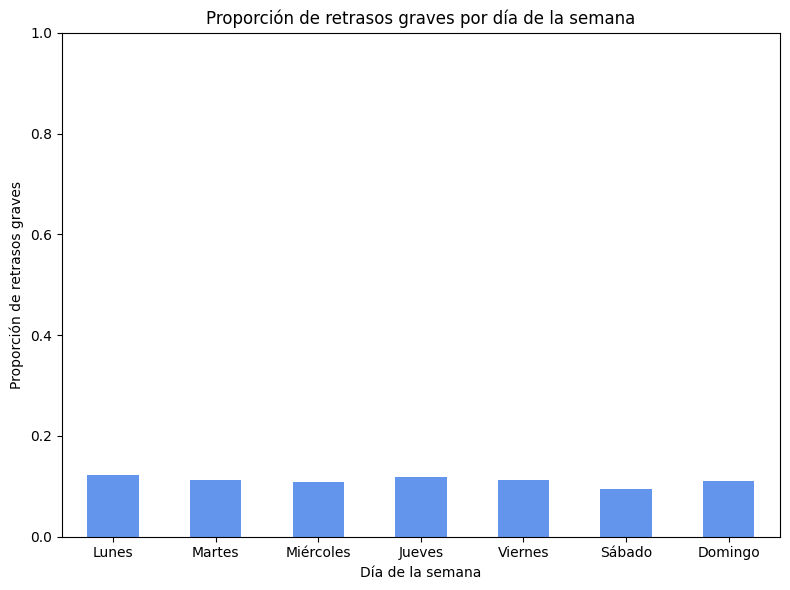

In [17]:
import matplotlib.pyplot as plt

# Crear columna si no existe
datos["DIA_SEMANA"] = datos["FECHA_COMPLETA"].dt.dayofweek

# Calcular proporción de retrasos graves por día de la semana
proporciones_dia = datos.groupby("DIA_SEMANA")["RETRASO_GRAVE"].mean()

# Mapear números a nombres de días
nombres_dias = {
    0: "Lunes", 1: "Martes", 2: "Miércoles", 3: "Jueves",
    4: "Viernes", 5: "Sábado", 6: "Domingo"
}
proporciones_dia.index = proporciones_dia.index.map(nombres_dias)

# Crear gráfico
plt.figure(figsize=(8,6))
proporciones_dia.plot(kind="bar", color="cornflowerblue")

plt.title("Proporción de retrasos graves por día de la semana")
plt.ylabel("Proporción de retrasos graves")
plt.xlabel("Día de la semana")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("Proporción_de_retrasos_graves_por_dia.png", dpi=300)
plt.show()

#**3. Modelo CatBoost de Predicción de Retrasos Graves en Vuelos**

In [18]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np

# ---------------------------
# 1. Target: retraso grave >= 30 min
# ---------------------------
causas = ['RETRASO_SISTEMA_AEREO','RETRASO_SEGURIDAD',
          'RETRASO_AEROLINEA','RETRASO_AVION_TARDIO','RETRASO_CLIMA']
datos["RETRASO_TOTAL"] = datos[causas].sum(axis=1)
datos["RETRASO_GRAVE"] = (datos["RETRASO_TOTAL"] >= 30).astype(int)

# ---------------------------
# 2. Feature engineering de partida
# ---------------------------
datos["FECHA_COMPLETA"] = pd.to_datetime(
    datos[["ANO","MES","DIA"]].rename(columns={"ANO":"year","MES":"month","DIA":"day"})
)

datos["DIA_SEMANA"] = datos["FECHA_COMPLETA"].dt.dayofweek
datos["MES_PARTIDA"] = datos["FECHA_COMPLETA"].dt.month
datos["ES_FIN_DE_SEMANA"] = datos["DIA_SEMANA"].isin([5,6]).astype(int)

datos["TEMPORADA"] = pd.cut(datos["MES_PARTIDA"],
                            bins=[0,3,6,9,12],
                            labels=["Verano","Otoño","Invierno","Primavera"],
                            right=True)

# ---------------------------
# 3. Variables de llegada
# ---------------------------
datos["HORA_LLEGADA"] = pd.to_numeric(datos["HORA_LLEGADA"], errors="coerce")
datos["HORA_LLEGADA"] = datos["HORA_LLEGADA"].fillna(datos["HORA_LLEGADA"].mean()).astype(int)

datos["FRANJA_HORARIA_LLEGADA"] = pd.cut(datos["HORA_LLEGADA"],
                                         bins=[0,6,12,18,24],
                                         labels=["Madrugada","Mañana","Tarde","Noche"],
                                         right=False)

# ---------------------------
# 4. Nueva variable: LLEGADA_PROGRAMA
# ---------------------------
datos["LLEGADA_PROGRAMA"] = pd.to_numeric(datos["LLEGADA_PROGRAMA"], errors="coerce")
datos["LLEGADA_PROGRAMA"] = datos["LLEGADA_PROGRAMA"].fillna(datos["LLEGADA_PROGRAMA"].mean()).astype(int)

datos["FRANJA_LLEGADA_PROGRAMA"] = pd.cut(datos["LLEGADA_PROGRAMA"],
                                          bins=[0,6,12,18,24],
                                          labels=["Madrugada","Mañana","Tarde","Noche"],
                                          right=False)

# ---------------------------
# 5. Features finales
# ---------------------------
X = datos[[
    "AEROLINEA","AEROPUERTO_ORIGEN","AEROPUERTO_DESTINO",
    "DISTANCIA","DIA_SEMANA","MES_PARTIDA","ES_FIN_DE_SEMANA",
    "TEMPORADA",
    "HORA_LLEGADA","FRANJA_HORARIA_LLEGADA",
    "LLEGADA_PROGRAMA","FRANJA_LLEGADA_PROGRAMA"
]]
y = datos["RETRASO_GRAVE"]

categorical_cols = [
    "AEROLINEA","AEROPUERTO_ORIGEN","AEROPUERTO_DESTINO",
    "FRANJA_HORARIA_LLEGADA","FRANJA_LLEGADA_PROGRAMA","DIA_SEMANA","TEMPORADA"
]

# Limpieza automática
for col in categorical_cols:
    X.loc[:, col] = X[col].astype(str).fillna("missing")

num_cols = ["DISTANCIA","DIA_SEMANA","MES_PARTIDA","ES_FIN_DE_SEMANA",
            "HORA_LLEGADA","LLEGADA_PROGRAMA"]
for col in num_cols:
    X.loc[:, col] = pd.to_numeric(X[col], errors="coerce")
    X.loc[:, col] = X[col].fillna(X[col].mean())

# ---------------------------
# 6. Train/Test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# 7. Modelo CatBoost
# ---------------------------
at_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=5,
    random_seed=42,
    verbose=100,
    class_weights=[1, len(y_train[y_train==0]) / len(y_train[y_train==1])]
)

at_model.fit(
    X_train, y_train,
    cat_features=categorical_cols,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

# ---------------------------
# 8. Evaluación con umbral fijo = 0.7912
# ---------------------------
y_proba = at_model.predict_proba(X_test)[:,1]

umbral_optimo = 0.7912
y_pred_opt = (y_proba >= umbral_optimo).astype(int)

print("Umbral fijo:", umbral_optimo)
print("Precisión:", precision_score(y_test,y_pred_opt))
print("Recall:", recall_score(y_test,y_pred_opt))
print("F1:", f1_score(y_test,y_pred_opt))
print("Matriz de confusión:\n", confusion_matrix(y_test,y_pred_opt))
print("ROC-AUC:", roc_auc_score(y_test,y_proba))

/tmp/ipython-input-797594670.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Mañana' 'Tarde' 'Tarde' ... 'Mañana' 'Madrugada' 'Mañana']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(str).fillna("missing")
/tmp/ipython-input-797594670.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Mañana' 'Tarde' 'Tarde' ... 'Mañana' 'Madrugada' 'Mañana']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(str).fillna("missing")
/tmp/ipython-input-797594670.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['3' '3' '3' ... '3' '3' '3']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.lo

0:	learn: 0.6836883	test: 0.6837011	best: 0.6837011 (0)	total: 11.3s	remaining: 3h 7m 29s
100:	learn: 0.4350429	test: 0.4361876	best: 0.4361876 (100)	total: 12m 11s	remaining: 1h 48m 34s
200:	learn: 0.3406936	test: 0.3419550	best: 0.3419550 (200)	total: 25m 23s	remaining: 1h 40m 54s
300:	learn: 0.2874767	test: 0.2888278	best: 0.2888278 (300)	total: 38m 50s	remaining: 1h 30m 13s
400:	learn: 0.2612405	test: 0.2626773	best: 0.2626773 (400)	total: 51m 54s	remaining: 1h 17m 31s
500:	learn: 0.2456286	test: 0.2471395	best: 0.2471395 (500)	total: 1h 5m 5s	remaining: 1h 4m 50s
600:	learn: 0.2331676	test: 0.2347514	best: 0.2347514 (600)	total: 1h 18m 15s	remaining: 51m 57s
700:	learn: 0.2266556	test: 0.2282623	best: 0.2282623 (700)	total: 1h 31m 10s	remaining: 38m 53s
800:	learn: 0.2222793	test: 0.2239328	best: 0.2239328 (800)	total: 1h 44m 3s	remaining: 25m 51s
900:	learn: 0.2184137	test: 0.2201540	best: 0.2201540 (900)	total: 1h 56m 49s	remaining: 12m 50s
999:	learn: 0.2157336	test: 0.2175249	

#**📌 Flujo completo**

- Definición del target (RETRASO_GRAVE)
- Se calcula como 1 si la suma de las causas de retraso (RETRASO_TOTAL) es ≥ 30 minutos.
- Es decir, el modelo aprende a distinguir entre vuelos con retraso grave (≥30 min) y vuelos puntuales (<30 min).

**Entrenamiento del modelo**

- El modelo se entrena para predecir la probabilidad de que un vuelo pertenezca a la clase RETRASO_GRAVE = 1.

**Por ejemplo:**

- Si el modelo devuelve 0.6, significa que estima un 60% de probabilidad de retraso ≥30 min.
- Si devuelve 0.9, significa un 90% de probabilidad de retraso ≥30 min.
- Uso del umbral (0.7912)


**El modelo CatBoost logra un muy buen balance:**

- Detecta la mayoría de los retrasos graves (recall alto).
- Mantiene una precisión aceptable (evita demasiados falsos positivos).
- El AUC cercano a 1 confirma que es un clasificador muy sólido.



#**MATRIZ DE CONFUSIÓN**

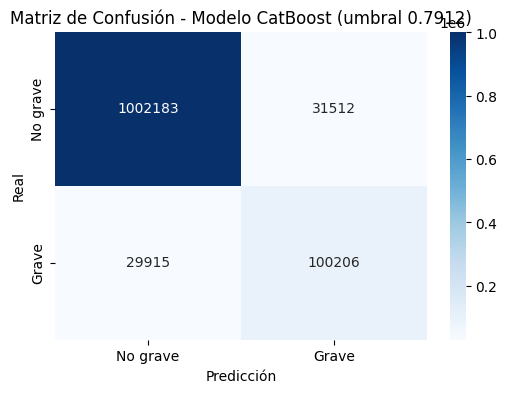

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matriz de confusión con tus predicciones
cm = confusion_matrix(y_test, y_pred_opt)

# Visualización con seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No grave','Grave'],
            yticklabels=['No grave','Grave'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Modelo CatBoost (umbral 0.7912)")

# Guardar como imagen PNG
plt.savefig("confusion_matrix.png")
plt.show()




**✅ Análisis**

- La matriz de confusión muestra los resultados concretos con el umbral= 0.7912: cuántos vuelos fueron clasificados correctamente y dónde están los errores.
- El modelo tiene un altísimo número de verdaderos negativos (1,002,183), lo que refleja que clasifica muy bien los vuelos puntuales.
- Los verdaderos positivos (100,206) también son significativos, mostrando buena capacidad para detectar retrasos graves.
- Los falsos positivos (31,512) son vuelos puntuales que el modelo marcó como retrasados. Esto puede generar “alarmas falsas”, pero es un número relativamente bajo frente al total.
- Los falsos negativos (29,915) son vuelos retrasados que el modelo no detectó. Este es el error más crítico, porque significa que algunos retrasos graves pasan desapercibidos.

**📌 Métricas derivadas**

- Precisión (Precision) ≈ 0.76 → de todos los vuelos que el modelo predijo como “Grave”, el 76% realmente lo eran.
- Recall (Sensibilidad) ≈ 0.77 → el modelo detecta correctamente el 77% de los vuelos con retraso grave.
- F1-score ≈ 0.76 → equilibrio entre precisión y recall.
- ROC-AUC ≈ 0.97 → excelente capacidad de discriminación global entre vuelos puntuales y retrasados.


#**ROC-AUC = 0.971.**


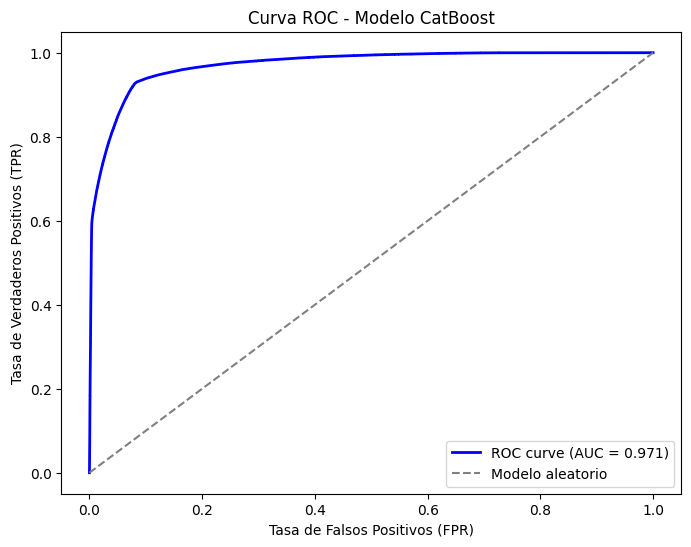

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilidades de la clase positiva (retraso grave)
y_proba = at_model.predict_proba(X_test)[:,1]

# Calcular puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
roc_auc = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color="gray", linestyle="--", label="Modelo aleatorio")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Modelo CatBoost")
plt.legend(loc="lower right")

# Guardar como imagen PNG
plt.savefig("Curva ROC.png")
plt.show()




**✅ Interpretación de tu resultado**

- Esto significa que el modelo es capaz de distinguir correctamente entre vuelos con retraso grave y vuelos puntuales en el 97% de los casos.

- En términos prácticos: si se toma un vuelo retrasado y uno puntual al azar, hay un 97% de probabilidad de que el modelo asigne una mayor probabilidad de retraso al vuelo retrasado.

- El ROC-AUC no depende de un umbral fijo (como el 0.7912). Evalúa el modelo en todos los posibles umbrales.



In [ ]:
at_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,HORA_LLEGADA,51.613366
1,LLEGADA_PROGRAMA,40.374843
2,FRANJA_HORARIA_LLEGADA,4.238255
3,FRANJA_LLEGADA_PROGRAMA,2.640583
4,AEROLINEA,0.539006
5,MES_PARTIDA,0.210461
6,AEROPUERTO_DESTINO,0.172964
7,DISTANCIA,0.084732
8,AEROPUERTO_ORIGEN,0.071130
9,TEMPORADA,0.036600


In [ ]:
print("Mejor iteración:", at_model.get_best_iteration())
print("Mejor score:", at_model.get_best_score())

Mejor iteración: 999
Mejor score: {'learn': {'Logloss': 0.21573356285860207}, 'validation': {'Logloss': 0.2175249293483713}}



**Nota:** Logloss (también llamado logistic loss o cross‑entropy loss) es una métrica que mide qué tan bien un modelo de clasificación que entrega probabilidades se ajusta a las etiquetas reales. Cuanto más bajo es el logloss, mejor está calibrado el modelo.


In [ ]:
proba = at_model.predict_proba(X_test)[:,1]
retrasados = X_test[proba >= 0.7912].copy()
retrasados["probabilidad"] = proba[proba >= 0.7912]
print(retrasados.head())

        AEROLINEA AEROPUERTO_ORIGEN AEROPUERTO_DESTINO   DISTANCIA DIA_SEMANA  \
1705180        WN               MCO                BNA   991.35344          6   
1980044        EV               FSM                ATL   931.80786          2   
770782         DL               MIA                LGA  1763.83664          4   
5549823        WN               MDW                FLL  1878.09978          0   
2042360        AA               DFW                STL   885.13700          6   

         MES_PARTIDA  ES_FIN_DE_SEMANA  TEMPORADA  HORA_LLEGADA  \
1705180            4                 1      Otoño            31   
1980044            5                 0      Otoño            35   
770782             2                 0     Verano            33   
5549823           12                 0  Primavera            34   
2042360            5                 1      Otoño            32   

        FRANJA_HORARIA_LLEGADA  LLEGADA_PROGRAMA FRANJA_LLEGADA_PROGRAMA  \
1705180                    nan    